In [22]:
import glob
import os
%load_ext autoreload
%autoreload 2

from astropy.io import fits, ascii
from ginga.util import zscale
import sewpy
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from photutils import aperture_photometry, CircularAperture, CircularAnnulus, DAOStarFinder, detect_threshold, Background2D
from astropy.wcs import WCS
from astropy.stats import sigma_clipped_stats
from wfc3_photometry import photometry_tools
import sys
sys.path.append('/Users/cshanahan/Desktop/WD_acs/scripts')
from run_phot import *


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
#look at photometry of one of the input FLCs vs. pipeline drizzle vs. custom drizzle

In [56]:
#custom drizzle
custom_drc = fits.open('/Users/cshanahan/Desktop/WD_acs/data/cmd_p9/F475W/F475W_combined_drc.fits')
custom_drc_sci = custom_drc[1].data
#pipeline drizzle product
pipeline_drc = fits.open('/grp/hst/wfc3s/deustua/ACSparallels/jcmdp9010_drc.fits')
pipeline_drc_sci = pipeline_drc[1].data
#flcs 
flcs = glob.glob('/Users/cshanahan/Desktop/WD_acs/data/cmd_p9/F475W/j*flc.fits')
fits.open(flcs[0])[0].header['ASN_TAB']

'jcmdp9010_asn.fits'

In [25]:
ra_targ1, dec_targ1 = fits.open(flcs[0])[0].header['ra_targ'], fits.open(flcs[0])[0].header['dec_targ']
print(ra_targ1, dec_targ1)
ra_targ2, dec_targ2 = fits.open(flcs[1])[0].header['ra_targ'], fits.open(flcs[1])[0].header['dec_targ']
print(ra_targ2, dec_targ2)
ra_targ3, dec_targ3 = fits.open(flcs[2])[0].header['ra_targ'], fits.open(flcs[2])[0].header['dec_targ']
print(ra_targ3, dec_targ3)


167.7857624244 -17.28023637444
167.7862684728 -17.2805736186
167.7852563786 -17.27989913017


In [26]:
#detect sources in DRC, chip by chip
mean, median, std = sigma_clipped_stats(custom_drc_sci, sigma=3.0)   
daofind = DAOStarFinder(fwhm=2.0, threshold=5*std, exclude_border = True)
cat_drc = daofind(custom_drc_sci)

/Users/cshanahan/miniconda3/envs/astroconda36/lib/python3.6/site-packages/astropy/stats/sigma_clipping.py:165: RuntimeWarning: invalid value encountered in greater
  _filtered_data.mask |= _filtered_data > max_value
/Users/cshanahan/miniconda3/envs/astroconda36/lib/python3.6/site-packages/astropy/stats/sigma_clipping.py:166: RuntimeWarning: invalid value encountered in less
  _filtered_data.mask |= _filtered_data < min_value
/Users/cshanahan/miniconda3/envs/astroconda36/lib/python3.6/site-packages/photutils/detection/core.py:256: RuntimeWarning: invalid value encountered in greater
  peak_goodmask = np.logical_and(peak_goodmask, (data > threshold))


In [27]:
# detect sources in pipeline DRC, chip by chip
daofind = DAOStarFinder(fwhm=2.0, threshold=0.8, exclude_border = True)
cat_pipeline_drc = daofind(pipeline_drc_sci)

/Users/cshanahan/miniconda3/envs/astroconda36/lib/python3.6/site-packages/photutils/detection/core.py:256: RuntimeWarning: invalid value encountered in greater
  peak_goodmask = np.logical_and(peak_goodmask, (data > threshold))


In [28]:
cat_pipeline_drcc = mask_sources_border_chipgap_drizzle_ACS(cat_pipeline_drc)

*** Filtering source catalog for sources within 50 pixels of top, bottom, and chipgap ***


In [29]:
cat_pipeline_drcc

id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag
int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64
91,353.01860734,87.7116806712,0.789225378707,0.471523102332,0.608301835871,25,0.0,1.35772025585,1.5092678892,-0.446915830512
109,1229.88950362,95.1463955871,0.964015682869,-0.100439910136,0.0465190475025,25,0.0,1.91451513767,2.07628744989,-0.793218697195
116,1382.0161323,98.804466264,0.83613245532,-0.148016948678,-0.137810983123,25,0.0,2.04985284805,2.20148682309,-0.856790225879
132,1928.70472371,113.029110918,0.813247864059,0.592062483808,0.162391898465,25,0.0,0.928841590881,1.029983115,-0.0320752629173
158,3635.94090153,159.504610697,0.979910973939,0.434768382897,0.409089615273,25,0.0,4.0646905899,4.43861079244,-1.61811766201
159,74.2574251025,182.821025797,0.712869743008,0.192056378931,0.0297379436798,25,0.0,22.6945762634,23.9389809348,-3.44776414715
160,292.924112015,591.748668787,0.864792335322,-0.0343925743913,0.132689987077,25,0.0,1.57445883751,1.80305989023,-0.640025381095
161,1154.43923883,666.769449033,0.679078178169,-0.0955522836997,-0.016221300564,25,0.0,1.46994698048,1.52736333668,-0.459855903618
162,3135.20370084,724.824798365,0.71431451745,0.317676105271,0.245423035877,25,0.0,2.50935077667,2.61807280781,-1.04495429995


In [30]:
#exclude sources on border and in chip gap
cat_drcc = cat_drc[(cat_drc['xcentroid'] > 300) & (cat_drc['xcentroid'] < 4214 - 300 ) &
                                     (cat_drc['ycentroid'] > 300) & (cat_drc['ycentroid'] < 4234 - 300)]
cat_drcc = cat_drcc[np.logical_or((cat_drcc['ycentroid'] > 2300),(cat_drcc['ycentroid'] < 2000))]
#add sky positions
w_drc = WCS(custom_drc[1].header)
ra_targs, dec_targs = w_drc.wcs_pix2world(cat_drcc['xcentroid'], cat_drcc['ycentroid'], 0)
cat_drcc['ra'] = ra_targs
cat_drcc['dec'] = dec_targs

In [31]:
#exclude sources on border and chip gap
# cat_pipeline_drcc = cat_pipeline_drc[(cat_pipeline_drc['xcentroid'] > 300) & (cat_pipeline_drc['xcentroid'] < 4214-300) &
#                                      (cat_pipeline_drc['ycentroid'] > 300) & (cat_pipeline_drc['ycentroid'] < 4324-300)]
# cat_pipeline_drcc = cat_pipeline_drcc[np.logical_or((cat_pipeline_drcc['ycentroid'] > 2300),

# top_line = lambda x : 0.05*x + 4115
# bottom_line = lambda x : 0.03*x

# cat_pipeline_drcc = cat_pipeline_drc[np.abs((top_line(cat_pipeline_drc['xcentroid']))-
#                                             cat_pipeline_drc['ycentroid'])>50]
# cat_pipeline_drcc = cat_pipeline_drcc[np.abs((bottom_line(cat_pipeline_drcc['xcentroid']))-
#                                             cat_pipeline_drcc['ycentroid'])>50]
# chip_line = lambda x: 0.04*x + 2078

# cat_pipeline_drcc = cat_pipeline_drcc[np.abs((chip_line(cat_pipeline_drcc['xcentroid']))-
#                                             cat_pipeline_drcc['ycentroid'])>50]
#0.05*4000 + 4100
# #add sky positions
w_pipeline_drc = WCS(pipeline_drc[1].header)
ra_targs, dec_targs = w_pipeline_drc.wcs_pix2world(cat_pipeline_drcc['xcentroid'], cat_pipeline_drcc['ycentroid'], 0)
cat_pipeline_drcc['ra'] = ra_targs
cat_pipeline_drcc['dec'] = dec_targs

#convert ra_targ and dec_targ to x and y in drizzled frame
x_targ_drc, y_targ_drc = w_pipeline_drc.all_world2pix([ra_targ1, ra_targ2, ra_targ3], 
                                                      [dec_targ1, dec_targ2, dec_targ3], 0)
cat_pipeline_drcc['xcentroid'] = cat_pipeline_drcc['xcentroid'] + 1
cat_pipeline_drcc['ycentroid'] = cat_pipeline_drcc['ycentroid'] + 1
cat_pipeline_drcc.write('/Users/cshanahan/Desktop/WD_acs/data/cmd_p9/F475W/source_positions.csv', format = 'ascii.commented_header')
cat_pipeline_drcc['xcentroid'] = cat_pipeline_drcc['xcentroid'] - 1
cat_pipeline_drcc['ycentroid'] = cat_pipeline_drcc['ycentroid'] - 1

2077.72

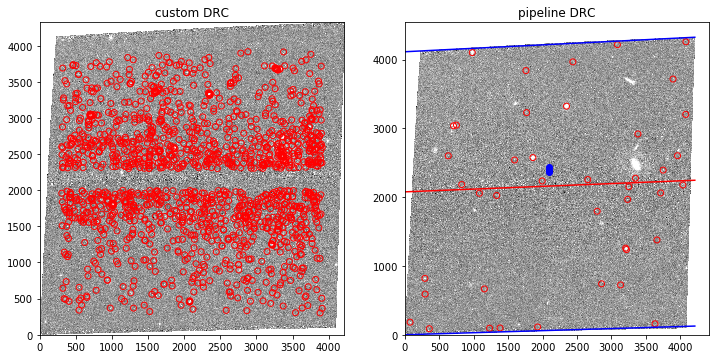

In [32]:
z1, z2 = zscale.zscale(custom_drc_sci)
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 12))
ax1.scatter(cat_drcc['xcentroid'], cat_drcc['ycentroid'], facecolor='None', edgecolor='r')
ax1.imshow(custom_drc_sci, origin = 'lower', vmin = z1, vmax = z2, cmap = 'Greys_r')
ax1.set_title('custom DRC')

z1, z2 = zscale.zscale(pipeline_drc_sci)
ax2.scatter(cat_pipeline_drcc['xcentroid'], cat_pipeline_drcc['ycentroid'], facecolor='None', edgecolor='r')
ax2.imshow(pipeline_drc_sci, origin = 'lower', vmin = z1, vmax = z2, cmap = 'Greys_r')
ax2.set_title('pipeline DRC')
ax2.scatter(x_targ_drc, y_targ_drc, c='b')
x = np.linspace(0,4214,1000)
plt.plot(x, 0.05*x + 4115, c = 'b')
plt.plot(x, 0.03*x, c = 'b')
plt.plot(x, 0.04*x + 2078, c= 'r')
4324/2. - 0.02*4214

In [33]:
#photometry on pipeline drc
apertures = CircularAperture((cat_pipeline_drcc['xcentroid'], cat_pipeline_drcc['ycentroid']) , r=10.)
background_apertures = CircularAnnulus((cat_pipeline_drcc['xcentroid'], cat_pipeline_drcc['ycentroid']), 20, 25)
medsky_drc = photometry_tools.aperture_stats_tbl(pipeline_drc_sci, background_apertures)['aperture_median']
phot_table_pipeline_drc = aperture_photometry(pipeline_drc_sci, apertures)   
phot_table_pipeline_drc['aperture_sum'] = phot_table_pipeline_drc['aperture_sum'] - medsky_drc


/Users/cshanahan/Desktop/WD_acs/wfc3_photometry/photometry_tools/background_median.py:93: RuntimeWarning: invalid value encountered in true_divide
  values = cutout * mask.data / mask.data


In [34]:
#photometry on custom drc
mean_drc, median_drc, std_drc = sigma_clipped_stats(custom_drc_sci, sigma=3.0, iters=5)
apertures = CircularAperture((cat_drcc['xcentroid'], cat_drcc['ycentroid']) , r=10.)
phot_table_drc = aperture_photometry(custom_drc_sci, apertures)    


/Users/cshanahan/miniconda3/envs/astroconda36/lib/python3.6/site-packages/astropy/stats/sigma_clipping.py:165: RuntimeWarning: invalid value encountered in greater
  _filtered_data.mask |= _filtered_data > max_value
/Users/cshanahan/miniconda3/envs/astroconda36/lib/python3.6/site-packages/astropy/stats/sigma_clipping.py:166: RuntimeWarning: invalid value encountered in less
  _filtered_data.mask |= _filtered_data < min_value


In [35]:
sew = sewpy.SEW(params=["X_IMAGE", "Y_IMAGE","FLUX_APER","FLAGS","ELLIPTICITY","FWHM"],
        config={"PIXEL SCALE": 0.5, "PHOT_APERTURES" : '10', "DETECT_MINAREA":500, 
                "FWHM":"2.5"})
out = sew("/Users/cshanahan/Desktop/WD_acs/data/cmd_p9/F475W/F475W_combined_drc.fits")
sextractor_table = out['table']

Parameter 'FWHM' seems strange and might be unknown to SExtractor
Known parameters are: 
#NUMBER                 Running object number                                     
#EXT_NUMBER             FITS extension number                                     
#FLUX_ISO               Isophotal flux                                             [count]
#FLUXERR_ISO            RMS error for isophotal flux                               [count]
#MAG_ISO                Isophotal magnitude                                        [mag]
#MAGERR_ISO             RMS error for isophotal magnitude                          [mag]
#FLUX_ISOCOR            Corrected isophotal flux                                   [count]
#FLUXERR_ISOCOR         RMS error for corrected isophotal flux                     [count]
#MAG_ISOCOR             Corrected isophotal magnitude                              [mag]
#MAGERR_ISOCOR          RMS error for corrected isophotal magnitude                [mag]
#FLUX_APER              F

Ouch, SExtractor complains :
b''


In [36]:
phot_table_pipeline_drc

id,xcenter,ycenter,aperture_sum
,pix,pix,
int64,float64,float64,float64
1,353.01860734011785,87.71168067123264,5.56979737394
2,1229.8895036245349,95.14639558713434,4.50364285839
3,1382.0161322957629,98.80446626401444,8.49659804878
4,1928.7047237063916,113.02911091798086,5.62411237376
5,3635.940901528181,159.5046106974072,8.37906615053
6,74.25742510250859,182.82102579726035,173.624801665
7,292.9241120152426,591.7486687868035,4.83573334918
8,1154.4392388281658,666.7694490333987,12.6241361525


In [37]:
sextractor_table[sextractor_table['ELLIPTICITY'] < 0.3]

X_IMAGE,Y_IMAGE,FLUX_APER,FLAGS,ELLIPTICITY
pix,pix,ct,,
float64,float64,float64,int64,float64
1655.9232,152.674,7.174377,0,0.273
963.9388,725.4709,2.1188,2,0.237
291.1544,821.27,318.6642,0,0.11
2875.3125,780.437,9.181006,0,0.252
4090.2388,971.0615,21.15738,0,0.124
3209.6216,1260.9119,690.3188,2,0.126
3221.4263,1240.3138,195.5437,2,0.288
2853.5281,1625.3988,4.928145,2,0.222


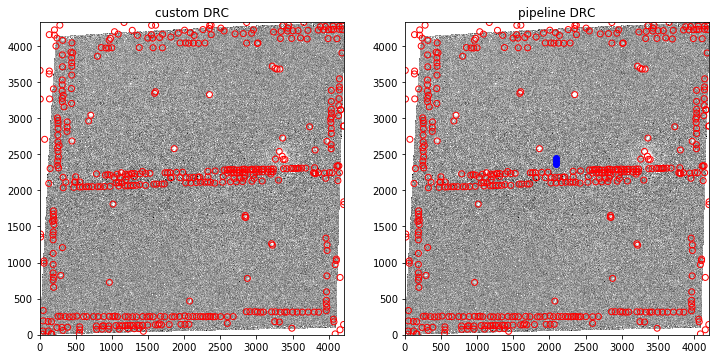

In [38]:
z1, z2 = zscale.zscale(custom_drc_sci)
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 12))
ax1.scatter(sextractor_table['X_IMAGE'], sextractor_table['Y_IMAGE'], facecolor='None', edgecolor='r')
ax1.imshow(custom_drc_sci, origin = 'lower', vmin = z1, vmax = z2, cmap = 'Greys_r')
ax1.set_title('custom DRC')

z1, z2 = zscale.zscale(pipeline_drc_sci)
ax2.scatter(sextractor_table['X_IMAGE'], sextractor_table['Y_IMAGE'], facecolor='None', edgecolor='r')
ax2.imshow(pipeline_drc_sci, origin = 'lower', vmin = z1, vmax = z2, cmap = 'Greys_r')
ax2.set_title('pipeline DRC')
ax2.scatter(x_targ_drc, y_targ_drc, c='b')

In [39]:
pipeline_drc[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
                                                                                
TELESCOP= 'HST'                / telescope used to acquire data                 
INSTRUME= 'ACS   '             / identifier for instrument used to acquire data 
                                                                                
              / DATA DESCRIPTION KEYWORDS                                       
                                                                                
IMAGETYP= 'EXT              

In [40]:
from photutils import detect_sources
from astropy.stats import gaussian_fwhm_to_sigma
from astropy.convolution import Gaussian2DKernel

In [41]:
sigma = 2. * gaussian_fwhm_to_sigma
kernel = Gaussian2DKernel(sigma, x_size=2, y_size=2)
kernel.normalize()
segm = detect_sources(pipeline_drc_sci, 0.03, npixels=10, filter_kernel=kernel)

/Users/cshanahan/miniconda3/envs/astroconda36/lib/python3.6/site-packages/photutils/segmentation/detect.py:128: RuntimeWarning: invalid value encountered in greater
  check_normalization=True) > threshold)


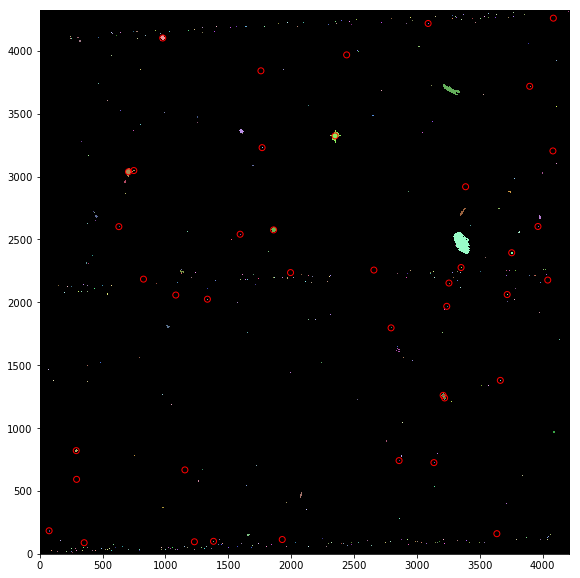

In [42]:
plt.figure(figsize = (10,10))
plt.imshow(segm, origin='lower',cmap=segm.cmap(random_state=12345))
plt.scatter(cat_pipeline_drcc['xcentroid'], cat_pipeline_drcc['ycentroid'], facecolor='None', edgecolor='r')

In [43]:
pipeline_drc_sci[0]

array([ 0.00481863,  0.03094738,  0.00773727, ...,         nan,
               nan,         nan], dtype=float32)

In [44]:
fits.open(flcs[0])[1].header['NAXIS2']

2048

In [45]:
input_file = '/Users/cshanahan/Desktop/WD_acs/data/cmd_p9/F475W/F475W_combined_drc.fits'

In [46]:
bkg = Background2D(custom_drc_sci, box_size = (100,100))

/Users/cshanahan/miniconda3/envs/astroconda36/lib/python3.6/site-packages/astropy/stats/sigma_clipping.py:165: RuntimeWarning: invalid value encountered in greater
  _filtered_data.mask |= _filtered_data > max_value
/Users/cshanahan/miniconda3/envs/astroconda36/lib/python3.6/site-packages/astropy/stats/sigma_clipping.py:166: RuntimeWarning: invalid value encountered in less
  _filtered_data.mask |= _filtered_data < min_value


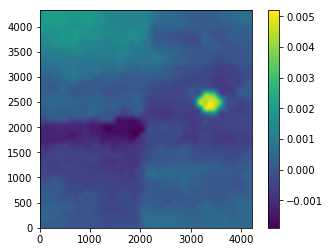

In [47]:
plt.imshow(bkg.background, origin = 'lower')
plt.colorbar()

In [48]:
threshold = bkg.background + (2. * bkg.background_rms)

In [49]:
a = photometry_tools.rad_prof.RadialProfile(20, 20, pipeline_drc_sci)

In [50]:
a.fwhm

0.95286102539423678

In [54]:
phot_table_pipeline_drc['xcenter'][0].value

353.01860734011785